In [1]:
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
# define random seeds for deterministic results
seed = 4242
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# read data
csv = pd.read_csv('training_w_labels1.csv')
texts = csv['title'].values
labels = csv['type_1_positive_change_+1week'].values

examples: 55035
labels: 55035


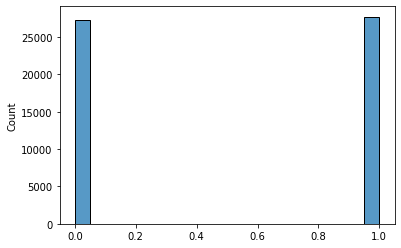

In [4]:
print('examples:', len(texts))
print('labels:', len(labels))

sns.histplot(labels)

In [5]:
def calculate_class_weights(labels, return_dict=True, first_class_index=0):
    if isinstance(labels[0], list) or isinstance(labels[0], np.ndarray):
        labels = [y.argmax() for y in labels]

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    if return_dict:
        weight_dict = {}
        for key in range(len(class_weights)):
            weight_dict[key + first_class_index] = class_weights[key]
        return weight_dict
    else:
        return class_weights

In [6]:
# input data restrictions
vocabulary = 10000
length = 100

In [7]:
# tokenizer texts (filters for punctuation)
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(texts)

#if save_model:
#    torch.save(tokenizer, f'models/{model_name}.tokenizer')

# tansform texts to padded sequences
sequences = tokenizer.texts_to_sequences(texts)
sequences = pad_sequences(sequences, maxlen=length, truncating='post', padding='pre')

# compute balanced class weights if needed
#class_weights = calculate_class_weights(labels=labels)

# train / test split and shuffle
x_train, x_test, y_train, y_test = train_test_split(sequences, labels, random_state=seed, test_size=0.2)

In [8]:
class ArrayDataSet(Dataset):
    def __init__(self, x, y, t):
        self.X = torch.tensor(x, dtype=t)
        self.Y = torch.tensor(y, dtype=t)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])

In [9]:
batch_size = 64

# setup data loaders for training and evaluation
train_loader = DataLoader(dataset=ArrayDataSet(x=x_train, y=y_train, t=torch.long),
                          batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=ArrayDataSet(x=x_test, y=y_test, t=torch.long),
                          batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
features = 200
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocabulary, embedding_dim=features)
        self.convolutions = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, features)),
                                           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(11, features)),
                                           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(17, features)),
                                           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(25, features)),
                                           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(32, features))])
        self.fc1 = nn.Linear(in_features=64 * len(self.convolutions), out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=2)

    def forward(self, x):
        x = self.embeddings(x)
        x = torch.unsqueeze(x, dim=1)
        xs = []
        for convolution in self.convolutions:
            c = F.softplus(convolution(x))
            c = torch.squeeze(c)
            c = F.max_pool1d(c, kernel_size=c.size()[2])
            xs.append(c)
        x = torch.cat(xs, dim=2)
        x = x.view(x.size()[0], -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.fc2(x)
        return x

In [11]:
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocabulary, embedding_dim=features)
        self.lstm_1 = nn.LSTM(input_size=features, hidden_size=32, num_layers=3, dropout=0.125,
                              bidirectional=True, batch_first=True)
        # self.lstm_2 = nn.LSTM(input_size=32 * length, hidden_size=32, num_layers=1, dropout=0.125,
        #                       bidirectional=True, batch_first=True)
        #self.fc1 = nn.Linear(in_features=256, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):
        # print(x.shape)
        x = self.embeddings(x)
        # print(x.shape)
        x, _ = self.lstm_1(x)
        # print(x.shape)
        x = x[:, -1, :]
        # h = torch.cat(h, dim=1)
        # print('h:', h.shape)
        # print(x.shape)
        # x = x.reshape(x.shape[0], -1)
        # print(x.shape)
        # x, h = self.lstm_2(x)
        # print(x.shape)
        #x = self.fc1(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

In [12]:
device = 'cuda' # change to cpu for cpu and cuda for gpu training
net = LSTMNet().to(device)

In [13]:
t = torch.rand(batch_size, length).long().to(device)
p = net(t)
print(p.shape)

torch.Size([64, 2])


In [14]:
# optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9, eps=1e-07)
#class_weights = torch.tensor(list(class_weights.values())).type(torch.FloatTensor).cuda()

loss_function = nn.CrossEntropyLoss()
#loss_function = nn.MSELoss()

In [15]:
def evaluate():
    net.eval()

    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for batch_index, batch in enumerate(valid_loader):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # make predictions
            predictions = net(x_batch)
            # get loss
            loss = loss_function(predictions, y_batch)
            running_loss += loss.item()
            
            # count correct predictions
            predicted_classes = torch.max(predictions.data, dim=1)[1]
            total += y_batch.size(0)
            correct += (predicted_classes == y_batch).sum().item()

    net.train()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [17]:
epochs = 20

accuracies = []
losses = []
val_accuracies = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_index, batch in enumerate(train_loader):
        sys.stdout.write(f'\r{batch_index / len(train_loader) * 100:4.2f}%')
        sys.stdout.flush()
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # make predictions
        predictions = net(x_batch)
        # get loss
        loss = loss_function(predictions, y_batch)
        running_loss += loss.item()

        # calculate gradients using the loss
        optimizer.zero_grad()
        loss.backward()
        # perform optimizer step on the network parameters
        optimizer.step()

        # count correct predictions
        predicted_classes = torch.max(predictions.data, dim=1)[1]
        total += y_batch.size(0)
        correct += (predicted_classes == y_batch).sum().item()

    epoch_loss, epoch_acc = evaluate()
    result = f'[epoch: {epoch + 1:3d}] train_loss: {running_loss / total:7.3f}'
    result += f' - train_acc: {100 * correct / total:7.2f}% |'
    result += f' val_loss: {epoch_loss:7.3f} - val_acc: {100 * epoch_acc:7.2f}%'
    sys.stdout.write(f'\r{result}\n')

    accuracies.append(correct / total)
    losses.append(running_loss / total)
    val_accuracies.append(epoch_acc)
    val_losses.append(epoch_loss)

[epoch:   1] train_loss:   0.006 - train_acc:   80.38% | val_loss:   0.011 - val_acc:   65.55%
[epoch:   2] train_loss:   0.006 - train_acc:   82.42% | val_loss:   0.012 - val_acc:   65.40%
[epoch:   3] train_loss:   0.005 - train_acc:   83.88% | val_loss:   0.012 - val_acc:   66.50%
[epoch:   4] train_loss:   0.005 - train_acc:   85.36% | val_loss:   0.013 - val_acc:   66.93%
[epoch:   5] train_loss:   0.004 - train_acc:   86.26% | val_loss:   0.014 - val_acc:   67.39%
[epoch:   6] train_loss:   0.004 - train_acc:   87.56% | val_loss:   0.014 - val_acc:   67.46%
[epoch:   7] train_loss:   0.004 - train_acc:   88.43% | val_loss:   0.015 - val_acc:   68.02%
[epoch:   8] train_loss:   0.004 - train_acc:   89.16% | val_loss:   0.014 - val_acc:   67.53%
[epoch:   9] train_loss:   0.003 - train_acc:   89.63% | val_loss:   0.015 - val_acc:   68.15%
[epoch:  10] train_loss:   0.003 - train_acc:   90.42% | val_loss:   0.015 - val_acc:   68.60%
[epoch:  11] train_loss:   0.003 - train_acc:   91

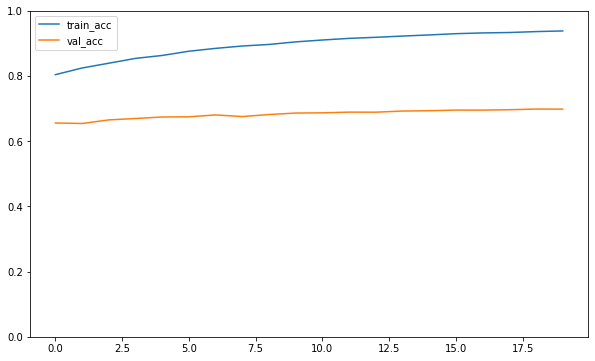

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(20), accuracies, label='train_acc')
plt.plot(range(20), val_accuracies, label='val_acc')
plt.ylim((0, 1))
plt.legend()
plt.show()

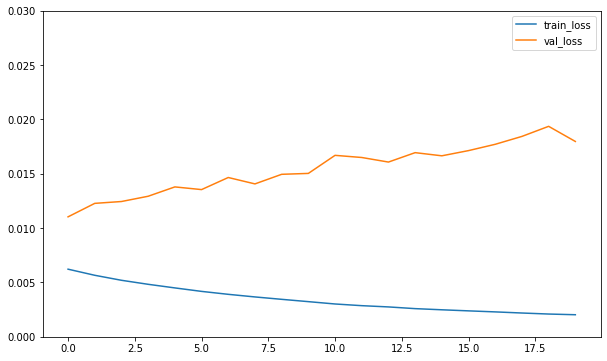

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(20), losses, label='train_loss')
plt.plot(range(20), val_losses, label='val_loss')
plt.ylim((0, 0.03))
plt.legend()
plt.show()